In [113]:
## NOTE!!!!
## We had difficulties using R in the jupyterlab environment (access data on S3, use the sf-package, etc.) 
## The code in this notebook was copied our local RStudios and therefore will not run here without fixing 
## the remaining issues.

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [120]:
#Libraries 
library(tmap)
library(tidyr)
library(ggplot2)
library(lubridate)
library(transformr)
library(dplyr)
library(zoo)
library(tidyverse)
library(aws.s3)
library(eurostat)
library(sf)
library(tmaptools)
library(terra)
library(factoextra)
library(NbClust)
library(ggthemes)
library("maps")
library("ggplot2")


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




In [121]:
# LOAD DATA 
## Map Data
nuts3_sf <- get_eurostat_geospatial(output_class = 'sf', 
                                    resolution ='60', 
                                    nuts_level = 3,
                                    year = 2016,
                                    crs = 4326)
## Import climate variables
data <- read.csv('preproc_seasonalv3.csv')



sf at resolution 1:60 read from local file

Warning message in get_eurostat_geospatial(output_class = "sf", resolution = "60", :
“Default of 'make_valid' for 'output_class="sf"' will be changed in the future (see function details).”


In [122]:
##Data transforation : selecting appropriate variables and taking the mean per year over the NUTS3
data_kmeans = data %>% 
  filter(sector %in% c("A")) %>%
  filter(year!="2002")%>%
  select(-c("X","area","sector","gdp","GVA","employment","population") )%>%
  select("geo", "LFI_WINTER", "LFI_SPRING", "LFI_SUMMER", "LFI_FALL", "APAR_WINTER", "APAR_SPRING", "APAR_SUMMER", "APAR_FALL", "SMA_WINTER",  "SMA_SPRING", "SMA_SUMMER", "SMA_FALL", "SPI_WINTER", "SPI_SPRING", "SPI_SUMMER" , "SPI_FALL","TMAX_WINTER_normal","TMAX_SPRING_normal","TMAX_SUMMER_normal","TMAX_FALL_normal","hi_WINTER","hi_SPRING","hi_SUMMER","hi_FALL" )%>% #,,"hi_WINTER","hi_SPRING","hi_SUMMER","hi_FALL" "SPI_WINTER","SPI_SPRING","SPI_SUMMER","SPI_FALL","TMAX_WINTER","TMAX_SPRING","TMAX_SUMMER","TMAX_FALL")%>% 
  group_by(geo)%>% #MAX_HI
  summarise_all(mean, na.rm=T)


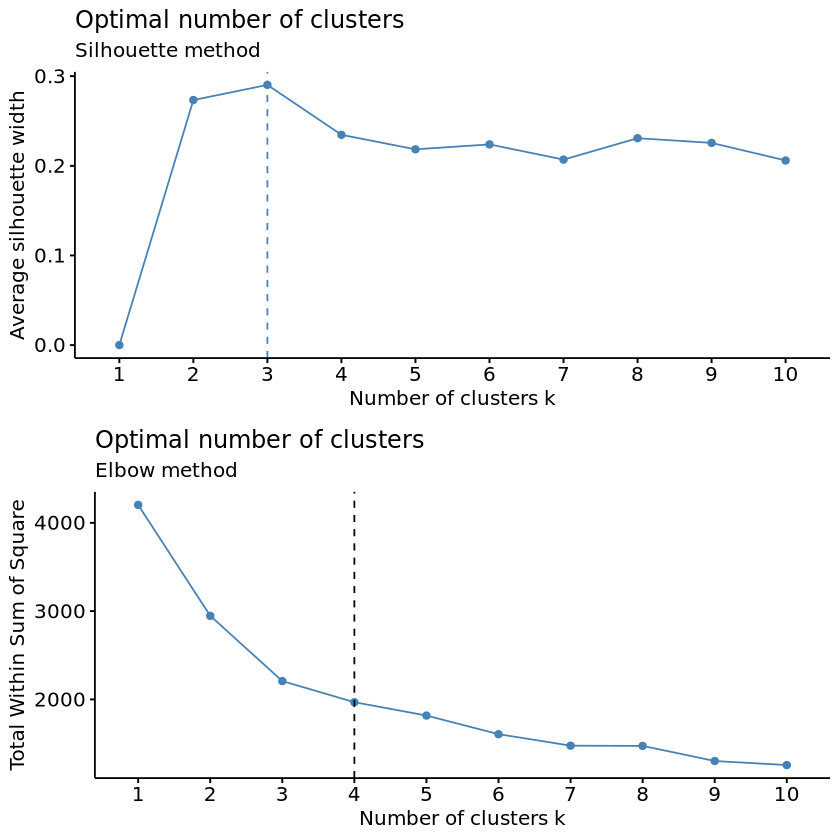

In [117]:
## Optimal number of clusters :  threee methods, elbow, silhouette and Gap statistic
# Elbow method
elbow= fviz_nbclust(data_kmeans[,-1] %>% na.omit(), kmeans, method = "wss") +
  geom_vline(xintercept = 4, linetype = 2)+
  labs(subtitle = "Elbow method")

# Silhouette method
silh = fviz_nbclust(data_kmeans[,-1]%>% na.omit(), kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")

# Gap statistic
set.seed(123)
#gap = Gap_stat = fviz_nbclust(data_kmeans[,-1], kmeans, nstart = 25,  method = "gap_stat", nboot = 50, k.max = 15)+
# labs(subtitle = "Gap statistic method")
 

gridExtra::grid.arrange(silh,elbow)
# --> choice of 10 catégories 

In [118]:
## Running chocen KMEANS
km.res <- kmeans(data_kmeans[,-1]%>% na.omit(), 10, nstart = 50)
temp = data.frame(geo=data_kmeans%>% na.omit()%>%select(geo),cluster=km.res$cluster)
data_kmeans=data_kmeans %>% left_join(temp)


Joining with `by = join_by(geo)`


In [ ]:
## Mapping the clusters
data_map <- inner_join(data_kmeans, nuts3_sf, by = c("geo")) 

ggplot(data_map) +
  geom_sf(aes(fill = as.factor(cluster), geometry = geometry)) +
  #scale_fill_viridis(option = "A", direction = -1) +  # Adjust the color scale
  theme_minimal() +
  xlim(-20,35)+
  ylim(30,70)



In [ ]:
## Plot the correlations
aggregate(data_kmeans[,-1], list(data_kmeans$cluster), mean)
with(data_kmeans[,2:20], pairs(data_kmeans[,-1], col=c(2:20)[data_kmeans$cluster]))

In [ ]:
## Output the clusters
NUTS = data %>%
  select(geo)%>%
  unique() %>%
  left_join(data_kmeans) 

  
NUTS$cluster[is.na(NUTS$cluster)] = 11

NUTS = NUTS %>% select(geo, cluster)
#write.csv(NUTS,'/cluster_climate_variables.csv')
